In [1]:
#Import packages. All of these packages should be included in anaconda distribution

import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.io import ascii
from astropy.coordinates import SkyCoord
import sys
import os
from scipy.optimize import curve_fit

In [2]:
#Instructions to install mwdust in README
#cell loads the dust maps in g filters. Other filters available 
#this takes a minute to run
os.environ['DUST_DIR'] = "/path/to/directory"
sys.path.insert(1,'path/to/mwdust-master')
import mwdust

dust_g= mwdust.Combined19(filter='SDSS g')

In [3]:
#function to fit each SDSS CV SED to the CV SED in question
def fit_reddening(SDSS_mag,b,A):
    griz_extinc = griz_extinc_global

    return SDSS_mag + b + A*griz_extinc
#function to apply the reddening 
def redden_SDSS(SDSS_mag,b,A):
    griz_extinc = griz_extinc_global

    return SDSS_mag + b + A*griz_extinc

In [10]:
#function that takes griz colors of a CV and estimates the reddening
def get_reddening(g_mag,r_mag,i_mag,z_mag):
    #store the photometry in one array
    decaps_mag_full = np.asarray([g_mag,r_mag,i_mag,z_mag])
    #make sure you have at least two detections in different filters
    if(np.sum(np.isfinite(decaps_mag_full))>1):
        decaps_lam = np.asarray([4800,6380,7770,9110]) #get array storing effective wavelegnth of griz in angstroms

        #extinction law wavelengths from Table 1 of Mathis 90
        extinc_lam = np.asarray([250,100,60,35,25,20,18,15,12,10,9.7,9.0,7,
                                    5,3.4,2.2,1.65,1.25,0.9,0.7,0.55,0.44,0.365,0.33,0.28,0.26])*1e-6
        #convert wavelength to frequnecy
        extinc_nu = 3e8/extinc_lam
        #conversion between J-band extinction to g-band
        g_over_J =  4.7
        #extinction values corresponding to the wavelgnth values in extinc_lam array
        extinc_mag = np.asarray([0.0015,0.0041,0.0071,0.013,0.048,0.075,0.083,0.053,0.098,0.192,0.208,0.157,0.070,
                                    0.095,0.182,0.382,0.624,1.,1.7,2.66,3.55,4.70,5.53,5.87,6.90,7.63])/g_over_J

        #here are the relative extinction values in griz filters
        griz_extinc = np.asarray([4.7,3,2.4,1.6])/g_over_J

        #load SDSS CV colors from KAto et al. 2012
        dn_color_tab = ascii.read('/Volumes/TopBloke/scripts/dn_colors.csv',comment='#',delimiter=';',data_start=3)
        #only keep lines where there is less than 0.5 mag of extinc
        AV_dn = dn_color_tab['AV']
        dn_color_tab = dn_color_tab[AV_dn<0.5]
        AV_dn = dn_color_tab['AV'] #extinction in V band

        #SDSS photometry in griz filters
        gmag_dn = np.asarray(dn_color_tab['gmag'])
        rmag_dn = np.asarray(dn_color_tab['rmag'])
        imag_dn = np.asarray(dn_color_tab['imag'])
        zmag_dn = np.asarray(dn_color_tab['zmag'])

        #error on SDSS photometry in griz filters
        e_gmag_dn = np.asarray(dn_color_tab['e_gmag'])
        e_rmag_dn = np.asarray(dn_color_tab['e_rmag'])
        e_imag_dn = np.asarray(dn_color_tab['e_imag'])
        e_zmag_dn = np.asarray(dn_color_tab['e_zmag'])
        
        #get rid of measurements with large uncertainties
        gmag_dn[e_gmag_dn>0.2]= np.nan
        rmag_dn[e_rmag_dn>0.2]= np.nan
        imag_dn[e_imag_dn>0.2]= np.nan
        zmag_dn[e_zmag_dn>0.2]= np.nan
        
        #get rid of measurements lower than limiting mag
        gmag_dn[gmag_dn>23.3] = np.nan
        rmag_dn[rmag_dn>23.1] = np.nan
        imag_dn[imag_dn>22.3] = np.nan
        zmag_dn[zmag_dn>20.8] = np.nan

        #create arrays to store extinction valus for each Kato CV
        A_SDSS = np.zeros(len(dn_color_tab))
        A_SDSS_err = np.zeros(len(dn_color_tab))
        b_SDSS = np.zeros(len(dn_color_tab))
        chi_i = np.zeros(len(dn_color_tab))

        #now loop through Kato CVs and estimate amount of extinction to make unreddened SED match our CV in question
        for i in range(len(dn_color_tab)):
            decaps_griz = decaps_mag_full
            SDSS_griz_place = np.asarray([gmag_dn[i],rmag_dn[i],imag_dn[i],zmag_dn[i]]) #store SDSS photometry in array
            e_arr_place = np.array([e_gmag_dn[i],e_rmag_dn[i],e_imag_dn[i],e_zmag_dn[i]]) #store error on SDSS photometry in array
            #conversion between J-band extinction to g-band
            V_over_J =  3.55
            #estimate amount of extinction in each band to de-redden the SED
            SDSS_extinc = np.asarray([4.7,3,2.4,1.6])/V_over_J*AV_dn[i]
            #this should be the unreddened SED of the Kato CV. We can now see how much reddening is needed to make this match our CV in question
            SDSS_griz_place -= SDSS_extinc
            
            #global variable for the extinction values
            global griz_extinc_global
            #only use Kato filters where there is a good measurement
            griz_extinc_global = griz_extinc[np.isfinite(SDSS_griz_place) & np.isfinite(e_arr_place) & np.isfinite(decaps_griz)]
            SDSS_griz=SDSS_griz_place[np.isfinite(SDSS_griz_place) & np.isfinite(e_arr_place) & np.isfinite(decaps_griz)]
            e_arr = e_arr_place[np.isfinite(SDSS_griz_place) & np.isfinite(e_arr_place)& np.isfinite(decaps_griz)]
            decaps_griz = decaps_griz[np.isfinite(SDSS_griz_place) & np.isfinite(e_arr_place) & np.isfinite(decaps_griz)]
            #only estimate reddening if we have at least 3 detections in different filters
            if(len(SDSS_griz)>2):
                #fit the reddening
                param_i, pcov = curve_fit(fit_reddening,SDSS_griz,decaps_griz,p0=(0,1))
                A_SDSS[i] = param_i[1]
                b_SDSS[i] = param_i[0]
                #error on the reddening
                A_SDSS_err[i] = np.sqrt(np.diag(pcov))[1]
                #get model from fitted params
                SDSS_red = fit_reddening(SDSS_griz,b_SDSS[i],A_SDSS[i])

                #calculate chi sqr
                chi_i[i] = np.sum((decaps_griz - SDSS_red)**2/e_arr**2/2)/(len(SDSS_griz)-2)

            else:
                A_SDSS[i] = np.nan
                b_SDSS[i] = np.nan
                A_SDSS_err[i] = np.nan
                chi_i[i] = np.nan

        #get rid of bad fit values
        A_SDSS[chi_i>100000] = np.nan
        if(len(chi_i[chi_i>10000])/len(chi_i)>.30):
            print('WARNING: Bad fit, the colors of this CV do not resemble a large fraction of CV colors from SDSS')
        #if we have at least 10 good fits
        if(np.sum(np.isfinite(A_SDSS))>10):
            #get the 2nd and 98th percentile values of the extinction distribution
            ext_98 = np.round(np.nanpercentile(A_SDSS,98),1)
            ext_2 = np.round(np.nanpercentile(A_SDSS,2),1)
            #get the median extinciton value
            ext_med = np.round(np.nanmedian(A_SDSS),1)
            
            #now plot the extinction value
            plt.rc('font', family='serif')
            fig, ax = plt.subplots(figsize=(11,8))
            plt.rc('font', family='sans-serif')

            ax.minorticks_on()
            ax.tick_params(axis='both', top = 'on', right ='on',which='major', direction='in', length = 10,width=1.1)
            ax.tick_params(axis='both', top = 'on', right ='on',which='minor', length=5, direction='in',width=1.1)
            ax.tick_params(axis='both', labelsize=14)

            plt.ylabel('N',size=18)
            plt.xlabel(r'A$_g$',size=18) 
            Ag_hist = ax.hist(A_SDSS,bins=np.arange(np.nanmin(A_SDSS)-0.1,np.nanmax(A_SDSS)+0.1,0.1),color='blue',density=True,linewidth=2,histtype='step')
            plt.axvline(ext_med,linestyle='--',linewidth=4,color='red')
            plt.fill_betweenx(y=[0,np.max(Ag_hist[0])],x1=ext_2,x2=ext_98,alpha=0.2,color='red')

            #plt.legend(fontsize=10)
            plt.show()
        else:
            ext_med = np.nan
            ext_2= np.nan
            ext_98= np.nan
    else:
        ext_med = np.nan
        ext_2= np.nan
        ext_98= np.nan
        A_SDSS = np.nan
        chi_i= np.nan
    
    return ext_med,ext_2,ext_98,A_SDSS,chi_i

In [11]:
#this function takes the position of the CV in decimal degrees, the peak magnitude,
#and the extinction values estimated in the above function to estimate the distance to the CV
def get_distance(ra_deg,dec_deg,peak,Ag,Ag_low,Ag_high,name):
    #get the extinction at this position as function of distance
    nova_M = np.array([-4.8,-10]) #range of absolute magnitude for classical nova
    dn_M = np.array([7,2]) #range of absolute magnitude dwarf nova

    coord = SkyCoord(ra_deg*u.deg,dec_deg*u.deg) #make a sky coordinate variable from position
    dist = np.arange(0.1,20.1,0.1) #array of distances up to 20 kpc

    #get the amount of g-band extinction as a function of distance at position of CV
    Ag_model = dust_g(coord.galactic.l.deg,coord.galactic.b.deg,dist)
    
    #try to estimate the median distance based on the distribution of possible extinction values
    #sometimes the CV color is too red for the map
    try:
        dist_med = dist[np.min(np.where(Ag<Ag_model))]#distance in kpc
    except:
        dist_med = 20
        
    #get min and max distances based on range of extinction values
    try:
        dist_min = dist[np.min(np.where(Ag_low<Ag_model))]
    except:
        dist_min = 20 #kpc
    try:
        dist_max = dist[np.min(np.where(Ag_high<Ag_model))]
    except:
        dist_max = 20 #kpc

    #get the apparent mag a nova and a dwarf nova would appear at this distance
    nova_apparent_mag = 5*np.log10(dist_med*1000) - 5 + np.mean(nova_M) + Ag_model[np.min(np.where(dist_med<dist))]
    nova_max =  5*np.log10(dist_min*1000) - 5 + np.min(nova_M) + Ag_model[np.min(np.where(dist_min<dist))]
    nova_min =  5*np.log10(dist_max*1000) - 5 + np.max(nova_M) + Ag_model[np.min(np.where(dist_max<dist))]
    dn_apparent_mag = 5*np.log10(dist_med*1000) - 5 + np.mean(dn_M) + Ag_model[np.min(np.where(dist_med<dist))]
    dn_max = 5*np.log10(dist_min*1000) - 5 + np.min(dn_M) + Ag_model[np.min(np.where(dist_min<dist))]
    dn_min = 5*np.log10(dist_max*1000) - 5 + np.max(dn_M) + Ag_model[np.min(np.where(dist_max<dist))]

    #difference in peak mag between a nova and the CV
    nova_diff = np.abs(nova_apparent_mag - peak)
    #difference in peak mag between a dwarf nova and the CV
    dn_diff = np.abs(dn_apparent_mag - peak)
    
    #see which type of transient is closer to the CV in question
    nova_flag = (peak < nova_min) & (peak>nova_max)
    dn_flag = (peak < dn_min) & (peak>dn_max)
    print('Ag = ',Ag)
                #####################PLOT##########################################
    plt.rc('font', family='serif')
    fig, ax = plt.subplots(figsize=(11,8))
    plt.rc('font', family='sans-serif')

    ax.minorticks_on()
    ax.tick_params(axis='both', top = 'on', right ='on',which='major', direction='in', length = 10,width=1.1)
    ax.tick_params(axis='both', top = 'on', right ='on',which='minor', length=5, direction='in',width=1.1)
    ax.tick_params(axis='both', labelsize=14)

    plt.title(name,size=18)
    plt.ylabel('Extinction (g mag)',size=18)
    plt.xlabel('distance (kpc)',size=18) 

    #plot the reddening as a function of distance
    plt.plot(dist,Ag_model,color='blue',linewidth=3,label=r'A$_g$ from 3D model')

    #plot the apparent color of transient
    ax.axhline(Ag,color='blue',linestyle='--',linewidth=2)
    ax.fill_between(dist,Ag_low,y2=Ag_high,color='blue',alpha=0.25)



    #show distance range
    plt.axvline(dist_med,color='black',linestyle='--',linewidth=2,label='distance')
    plt.fill_betweenx([0,1],dist_min, x2=dist_max,transform=ax.get_xaxis_transform(),alpha=0.25,color='black')

    plt.legend(fontsize=15)
    plt.show()



    print('Based on the color, this transient is',np.round(dist_min,1),'to',np.round(dist_max,1),
            'kpc away')
    print('')
    if(nova_flag & dn_flag):
        print('The colors are too uncertain to give a reliable classification')
        if(nova_diff<dn_diff):
            print('However this transient is only',np.round(nova_diff,1),' mags from the expected brightness of a CLASSICAL NOVA')
            class_result =1
        else:
            class_result =2
        print('However this transient is only',np.round(dn_diff,1),' mags from the expected brightness of a DWARF NOVA')
        print('CN range g =',np.round([nova_min,nova_max],1))
        print('DN range g =',np.round([dn_min,dn_max],1))
        print('Transient brightness =',np.round(peak,1))
    elif(nova_flag):
        class_result =0
        print('THIS TRANSIENT IS LIKELY A CLASSICAL NOVA')
        print('')
        print('At this distance, a nova should appear between g =',np.round([nova_min,nova_max],1))
        print('This is consistent with the transient brightness of g = ',np.round(peak,1))
        print('A dwarf nova, on the other hand, would appear between g =',np.round([dn_min,dn_max],1))
    elif(dn_flag):
        class_result =3
        print('THIS TRANSIENT IS LIKELY A DWARF NOVA')
        print('')
        print('At this distance, a dwarf nova should appear between g =',np.round([dn_min,dn_max],1))
        print('This is consistent with the transient brightness of g = ',np.round(peak,1))
        print('A nova, on the other hand, would appear between g =',np.round([nova_min,nova_max],1))
    else:
        print('This transient is NOT consistent with the brightness of a nova or a dwarf nova')
        if(nova_diff<dn_diff):
            class_result =1
            print('However this transient is only',np.round(nova_diff,1),' mags from the expected brightness of a CLASSICAL NOVA')
        else:
            class_result =2
            print('However this transient is only',np.round(dn_diff,1),' mags from the expected brightness of a DWARF NOVA')
        print('CN range g =',np.round([nova_min,nova_max],1))
        print('DN range g =',np.round([dn_min,dn_max],1))
        print('Transient brightness =',np.round(peak,1))
        

/Users/slimcharles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in greater

/Users/slimcharles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in greater

/Users/slimcharles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in greater

/Users/slimcharles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in greater

/Users/slimcharles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:91: RuntimeWarning: divide by zero encountered in true_divide

/Users/slimcharles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in greater

/Users/slimcharles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in greater



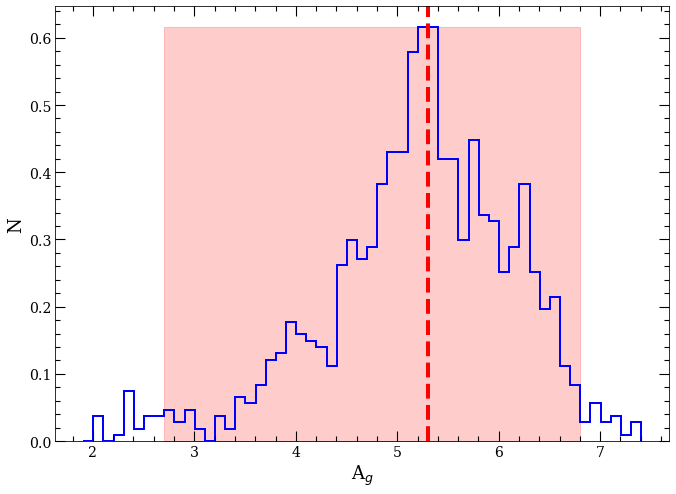

Ag =  5.3


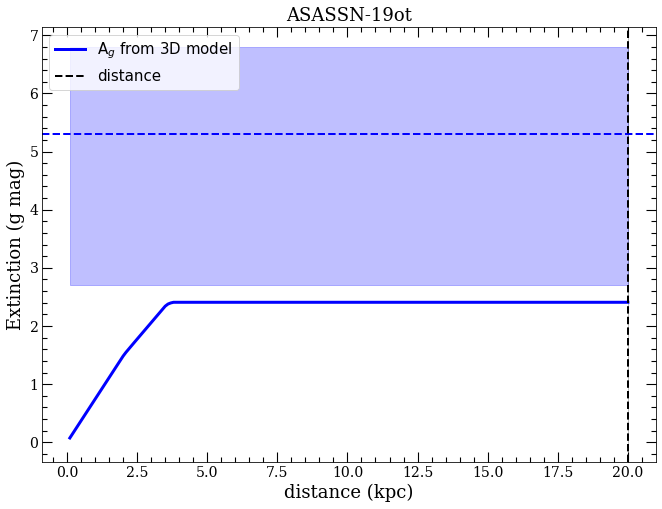

Based on the color, this transient is 20 to 20 kpc away

This transient is NOT consistent with the brightness of a nova or a dwarf nova
However this transient is only 3.5  mags from the expected brightness of a CLASSICAL NOVA
CN range g = [14.1  8.9]
DN range g = [25.9 20.9]
Transient brightness = 15.0


In [12]:
#example cell to run the program
#position of the source in ra and dec in decimal degrees
ra = 267.50208
dec = -37.12033
#peak magnitude of transient
peak_mag = 15.
#magnitude of object in various filters (can be from quiescense) enter np.nan if magnitude is not known
g_phot =22.2714
r_phot =20.393
i_phot = 19.24
z_phot = 18.6674
phot_err = 0.1 #estimate error in photometry
name = 'ASASSN-19ot'

Ag,Ag_low,Ag_high,Ag_array,chi_squared = get_reddening(g_phot,r_phot,i_phot,z_phot)
get_distance(ra,dec,peak_mag,Ag,Ag_low,Ag_high,name)